#I. Machine Prep

In [62]:
%pip install pandas
!apt install graphviz libgraphviz-dev
%pip install pygraphviz
%pip install powerlaw
%pip install networkx

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [61]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import accuracy_score, auc
import pprint
import numpy as np
from collections import OrderedDict
import powerlaw
import itertools as it

#I. Pedigree Simulation

In [4]:
def pedigree_generator(max_children, FamilyID, mode, generation_count, AffectedSpouse= False, BackpropLikelihood= False, alt_freq= 0):
        #-------------------------------------------
        # Helper Functions for Pedigree Propigation
        #-------------------------------------------

        '''
        Basic helper function to add new entry to pedigree dataframe
        '''
        def entry_generator(IndividualID, PaternalID, MaternalID, Sex, Phenotype, Genotype):
            nonlocal family_df
            family_df.loc[IndividualID] = [FamilyID, PaternalID, MaternalID, Sex, Phenotype, Genotype]

        '''
        Helper function to translate between genotype and phenotype
        Dependant on the mode of inheritance
        Input: genotype(int(0,1,2))
        Output: phenotype(int(1,2))
        '''
        def genotype_interpreter(genotype):
            if mode == 'AR':
                phenotype = 2 if genotype == 2 else 1
            if mode == 'AD':
                phenotype = 2 if genotype == 2 or genotype == 1 else 1
            return phenotype

        def calc_inheritance_weights(p,q):

            tt = q**4
            to = 2*p*(q**3)
            tz = (p**2)*(q**2)
            oo = 4*(p**2)*(q**2)
            oz = 2*(p**3)*(q)
            zz = p**4

            homoRef = p**2
            hetero = 2*p*q
            homoAlt = q**2

            inheritance_patterns = {
                'forward_genotypes': {
                #(paternal genotype, maternal genotype) -> [possible child genotypes]
                    (2,2): [2],
                    (2,1): [2,1],
                    (1,2): [2,1],
                    (2,0): [1],
                    (0,2): [1],
                    (1,1): [2,1,0],
                    (0,1): [1,0],
                    (1,0): [1,0],
                    (0,0): [0]
                },
                'forward_weights': {
                    (2,2): [1],
                    (2,1): [1,1],
                    (1,2): [1,1],
                    (2,0): [1],
                    (0,2): [1],
                    (1,1): [1,2,1],
                    (0,1): [1,1],
                    (1,0): [1,1],
                    (0,0): [1]
                },
                #child genotype -> [possible (paternal,maternal) genotypes]
                'reverse_genotypes': {
                    2: [(2,2),(2,1),(1,2),(1,1)],
                    1: [(2,1),(1,2),(2,0),(0,2),(1,1),(1,0),(0,1)],
                    0: [(1,0),(0,1),(0,0)]
                },
                'reverse_weights': {
                    2: [homoAlt**2, homoAlt*hetero, hetero*homoAlt, hetero**2],
                    1: [homoAlt*hetero, hetero*homoAlt, homoAlt*homoRef, homoRef*homoAlt, hetero**2, hetero*homoRef, homoRef*hetero],
                    0: [hetero*homoRef, homoRef*hetero, homoRef**2]
                }
            }

            return inheritance_patterns

        '''
        Wrapper function that generates the primary founder of the pedigree
        By default, this individual is affected
        If AD, 20% chance homozygous, 80% chance heterozygous.
        If AR, 100% chance homozygous.
        Input:
        Output:
        '''
        def primary_founder_generator():
            nonlocal family_df

            if mode == 'AD':
                Genotype = random.choices(population= [1,2],
                                          weights= (0.8, 0.2))[0]
            elif mode == 'AR':
                Genotype= 2

            entry_generator(IndividualID= 1,
                            PaternalID= 0,
                            MaternalID= 0,
                            Sex= random.randint(1,2),
                            Phenotype= 2,
                            Genotype= Genotype)
        '''
        Wrapper function that generates spouses unrelated to primary founder
        Spouse sex dependent on the relative of primary founder.
        Genotype and phenotype dependent on the mode of inheritance and affected spouse paramter.
        Input: relativeID(int)
        Ouput: n/a
        '''
        def spouse_generator(RelativeAnchorID):
            nonlocal family_df, alt_freq, ref_freq

            pp = ref_freq**2
            pq2 = 2*ref_freq*alt_freq
            qq = alt_freq**2

            Sex= 1 if family_df.loc[RelativeAnchorID]['Sex'] == 2 else 2

            if AffectedSpouse:
                Genotype= random.choices(population= [0,1,2],
                                          weights= (pp, pq2, qq),
                                          k=1)[0]

            else:
                Genotype = 0

            entry_generator(IndividualID= len(family_df)+1,
                            PaternalID= 0,
                            MaternalID= 0,
                            Sex= Sex,
                            Phenotype= genotype_interpreter(Genotype),
                            Genotype= Genotype)
        '''
        Wrapper function that generates an entry for the child of two given individuals.
        Child's genotype is chosen from list of allowed gentypes given parents genotypes with equal likelihood.
        Input: PaternalID(int), MaternalID(int)
        Output: n/a
        '''
        def child_generator(PaternalID, MaternalID):
            nonlocal family_df, inheritance_patterns

            parentalGenotype = (int(family_df.loc[PaternalID]['Genotype']), int(family_df.loc[MaternalID]['Genotype']))

            Genotype = random.choices(population= inheritance_patterns['forward_genotypes'][parentalGenotype],
                                      weights= inheritance_patterns['forward_weights'][parentalGenotype],
                                      k=1)[0]

            entry_generator(IndividualID= len(family_df)+1,
                            PaternalID= PaternalID,
                            MaternalID= MaternalID,
                            Sex= random.randint(1,2),
                            Phenotype= genotype_interpreter(Genotype),
                            Genotype= Genotype)
        #---------------------------------------
        # Primary Pedigree Contruction Functions
        #---------------------------------------
        '''
        Function that recursively constructs pedigree in backward direction.
        Infers ancestors of individuals unrelated to primary founder as they are added.
        Input: current_generation(int), RealativeAnchorID(int)
        Output: n/a
        '''
        def recursive_history_backprop(current_generation, RelativeAnchorID):
            nonlocal family_df, generation_count, inheritance_patterns, BackpropLikelihood

            BackpropRNG = random.randint(1,100)/100

            if current_generation > 0 and BackpropRNG <= BackpropLikelihood:

                GenotypeTup = random.choices(population= inheritance_patterns['reverse_genotypes'][family_df.loc[RelativeAnchorID]['Genotype']],
                                                    weights= inheritance_patterns['reverse_weights'][family_df.loc[RelativeAnchorID]['Genotype']],
                                                    k=1)[0]

                ID_list = ['PaternalID', 'MaternalID']

                for i in range(2):
                    entry_generator(IndividualID= len(family_df)+1,
                                    PaternalID= 0,
                                    MaternalID= 0,
                                    Sex= 1 + i,
                                    Phenotype= genotype_interpreter(GenotypeTup[i]),
                                    Genotype= GenotypeTup[i])
                    family_df.at[RelativeAnchorID, ID_list[i]] = len(family_df)
                    recursive_history_backprop(current_generation-1, len(family_df))

        '''
        Function that recursively constructs pedigree in forward direction.
        Input: current_generation(int), RelativeAnchorID(int)
        Output: n/a
        '''
        def recursive_pedigree_construction(current_generation, RelativeAnchorID):
            nonlocal family_df, max_children, generation_count

            if current_generation < generation_count-1:

                spouse_generator(RelativeAnchorID= RelativeAnchorID)

                #Determining Parental Sex for next generation
                if family_df.loc[RelativeAnchorID]['Sex'] == 1:
                    PaternalID = RelativeAnchorID
                    MaternalID = len(family_df)
                else:
                    PaternalID = len(family_df)
                    MaternalID = RelativeAnchorID

                if BackpropLikelihood:
                    recursive_history_backprop(current_generation, len(family_df))

                for child in range(random.randint(1, max_children)):
                    child_generator(PaternalID= PaternalID, MaternalID= MaternalID)
                    recursive_pedigree_construction(current_generation+1, len(family_df))


        #-------------------------------------
        # 1. Construct the empty data frame
        #-------------------------------------
        pedigree_construction_columns = ['FamilyID', 'IndividualID', 'PaternalID', 'MaternalID', 'Sex', 'Phenotype', 'Genotype']
        family_df = pd.DataFrame(columns= pedigree_construction_columns)
        family_df.set_index('IndividualID', inplace=True)

        #-------------------------------------
        # 2. Generating Primary Founder
        #-------------------------------------
        primary_founder_generator()

        #--------------------------------------------
        # 3. Construct Inheritence Pattern Dictionary
        #--------------------------------------------
        ref_freq = 1 - alt_freq
        inheritance_patterns = calc_inheritance_weights(ref_freq, alt_freq)

        #----------------------------------------
        # 4. Generating Pedigree
        #----------------------------------------
        recursive_pedigree_construction(current_generation= 0, RelativeAnchorID= 1)

        #-------------------------------
        # 5. Resetign Standard Indexing
        #-------------------------------
        family_df.reset_index(inplace= True)

        return family_df

#I. Variant Simulation

In [46]:
def simulate_variant_table(G, mode='AD', n_bg=5, seed=1):
    random.seed(seed)
    samples = list(G.nodes)
    phen = nx.get_node_attributes(G,'phenotype')
    vars = {}
    # causal
    causal = 'chr1:100000_A>T'
    gt = {s:0 for s in samples}
    if mode=='AD':
        for s in samples:
            if phen[s]==2:
                gt[s]=1
        any_aff = [n for n in samples if phen[n]==2][0]
        for p in G.predecessors(any_aff):
            gt[p]=1
    else:
        for s in samples:
            if phen[s]==2:
                gt[s]=2
                for p in G.predecessors(s):
                    gt[p]=1
    vars[causal]=gt
    # background
    for i in range(n_bg):
        vid=f'chr1:{100200+i}_G>C'
        vars[vid]={s:random.choices([0,1,2],[0.8,0.18,0.02])[0] for s in samples}
    return vars


#I. Pedigree Graph Conversion

In [5]:
def pedfile_readin(pedfile):
    cols = ['FamilyID', 'IndividualID', 'PaternalID', 'MaternalID', 'Sex', 'Phenotype', 'Genotype']
    df = pd.read_csv(pedfile, sep=r'\s+', header=None, names=cols)
    return df


def construct_pedigree_graph(df):
    G = nx.DiGraph()

    for _, row in df.iterrows():
        # Make sure IndividualID is treated as a string or int consistently if needed
        G.add_node(row['IndividualID'],
                  family=row['FamilyID'],
                  sex=row['Sex'],
                  phenotype=row['Phenotype'])

    for _, row in df.iterrows():
        # Ensure PaternalID and MaternalID are compared to string '0' if they are strings
        paternal_id = row['PaternalID']
        maternal_id = row['MaternalID']
        individual_id = row['IndividualID']

        if paternal_id != 0:
            G.add_edge(paternal_id, individual_id)
        if maternal_id != 0:
            G.add_edge(maternal_id, individual_id)

    return G

##Pedigree Graph Visualization

In [6]:
def plot_pedigree_tree(G, title="Pedigree (Tree Layout)"):
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        pos = graphviz_layout(G, prog='dot')  # 'dot' gives top-down DAG style
    except ImportError:
        print("PyGraphviz not installed. Falling back to spring layout.")
        pos = nx.spring_layout(G, seed=42)

    node_colors = ['red' if G.nodes[n]['phenotype'] == 2 else 'lightblue' for n in G.nodes]

    nx.draw(G, pos, with_labels=True, node_color=node_colors, arrows=True)
    plt.title(title)
    plt.show()

#I. Pedigree Graph Analysis

##II. Simple Pedigree Helper Functions

In [43]:
def parents(G, node):
    """Return a list of parent nodes for `node` (incoming edges)."""
    return list(G.predecessors(node))

def siblings(G, node):
    """Return siblings: nodes that share ≥ 1 parent with `node`."""
    sibs = set()
    for p in parents(G, node):
        sibs.update(G.successors(p))
    sibs.discard(node)
    return sibs
def generations(G):
    lvl={}
    Q=[(n,0) for n in G if G.in_degree(n)==0]
    while Q:
        n,d=Q.pop(0)
        if n in lvl: continue
        lvl[n]=d
        for c in G.successors(n): Q.append((c,d+1))
    return lvl

def aff(G):
    return [n for n,d in G.nodes(data='phenotype') if d==2]
def unaff(G):
    return [n for n,d in G.nodes(data='phenotype') if d!=2]

_ALLOWED_INHERITENCE = {
 'AD': {(0,0):{0}, (1,0):{0,1}, (0,1):{0,1}, (1,1):{0,1,2}, (2,'_'):{1,2}},
 'AR': {(0,0):{0}, (1,0):{0,1}, (0,1):{0,1}, (1,1):{0,1,2}, (2,'_'):{1,2}},
}

def allowed_child_set(mode,gp,gm):
    k=(gp,gm) if (gp,gm) in _ALLOWED_INHERITENCE[mode] else (gm,gp)
    if k not in _ALLOWED_INHERITENCE[mode]:
        k=(2,'_') if 2 in (gp,gm) else (1,'_')
    return _ALLOWED_INHERITENCE[mode].get(k,{0,1,2})

##II. Pedigree Feature Extraction and Metric Calculation

In [8]:
def pedigree_features(G):

    phen = nx.get_node_attributes(G,'phenotype')
    aff_nodes = [n for n,p in phen.items() if p==2]
    unaff_nodes = [n for n,p in phen.items() if p!=2]

    # ratio affected with affected parent
    aff_aff_parent = 0
    for n in aff_nodes:
        if any(phen.get(p,0)==2 for p in parents(G,n)):
            aff_aff_parent +=1
    ratio_aff_parent = aff_aff_parent/len(aff_nodes) if aff_nodes else 0

    # generation coverage
    gen = generations(G)
    gens_aff = {gen[n] for n in aff_nodes}
    gen_cov = len(gens_aff)/(max(gen.values())+1) if gen else 0

    # sibling clustering
    sib_pairs=0; aa_pairs=0
    for n in aff_nodes:
        for sib in siblings(G,n):
            if sib in aff_nodes:
                aa_pairs+=1
            sib_pairs+=1
    sibling_aff_ratio = aa_pairs/sib_pairs if sib_pairs else 0

    # betweenness carriers
    bet = nx.betweenness_centrality(G)
    carrier = [n for n in unaff_nodes if G.nodes[n].get('phenotype')!=2 and G.nodes[n].get('genotype') != 0]
    avg_bet_carrier = np.mean([bet[n] for n in carrier]) if carrier else 0
    avg_bet_unaff = np.mean([bet[n] for n in unaff_nodes]) if unaff_nodes else 0

    #new betweeness of carriers (with graph of only affected and carriers)
    # new_bet = nx.betweenness_centrality(G.subgraph(aff_nodes+carrier))
    # new_avg_bet_carrier = np.mean([new_bet[n] for n in carrier]) if carrier else 0

    features = dict(ratio_aff_parent=ratio_aff_parent, gen_cov=gen_cov, sibling_aff_ratio=sibling_aff_ratio, avg_bet_carrier=avg_bet_carrier, avg_bet_unaff=avg_bet_unaff)

    return features

In [29]:
def graph_metrics(G):
    """Return an OrderedDict of network statistics; robust to disconnected graphs."""
    G_u = G.to_undirected()
    metrics = OrderedDict()

    # ---------- basic sizes ----------
    metrics['n_nodes']   = G.number_of_nodes()
    metrics['n_edges']   = G.number_of_edges()
    metrics['n_components'] = nx.number_connected_components(G_u)

    # ---------- centralities (averaged over ALL nodes) ----------
    deg_cent  = list(nx.degree_centrality(G_u).values())
    bet_cent  = list(nx.betweenness_centrality(G_u).values())
    clos_cent = list(nx.closeness_centrality(G_u).values())
    metrics['avg_degree_centrality'] = float(np.mean(deg_cent))
    metrics['avg_betweenness']       = float(np.mean(bet_cent))
    metrics['avg_closeness']         = float(np.mean(clos_cent))

    # ---------- clustering ----------
    metrics['avg_clustering'] = nx.average_clustering(G_u)

    # ---------- choose a CORE (largest connected component) for path-metrics ----------
    core = G_u

    # ---------- diameter & average path on CORE ----------
    metrics['diameter'] = nx.diameter(core)
    metrics['avg_path_len'] = nx.average_shortest_path_length(core)

    # ---------- small-world sigma (CORE vs random ER) ----------
    #opted of plug-and-play sigma calculation from NetworkX over first principals calculation
    #parameters greatly lowered for threshold determination efficiency
    #metrics['sigma_small_world'] = nx.sigma(core, niter= 1, nrand= 1)
    metrics['sigma_small_world'] = 0


    # ---------- power-law exponent on full graph ----------
    degs = [d for _, d in G_u.degree()]
    fit = powerlaw.Fit(degs, discrete=True, verbose=False)
    metrics['pl_alpha'] = round(fit.power_law.alpha, 3)
    metrics['pl_xmin']  = fit.power_law.xmin


    return metrics

#I. Mode of Inheritence Classification

##II. Size-dependent Threshold Determination

In [27]:
def feature_data_generation(generation_count, trials):
    trial_result = {}
    all_trial_feats_df = pd.DataFrame(columns= ['actual_mode', 'ratio_aff_parent', 'gen_cov', 'sibling_aff_ratio', 'avg_bet_carrier', 'avg_bet_unaff', 'new_avg_bet_carrier',
                                                'n_nodes', 'n_edges', 'n_components',
                                                'avg_degree_centrality', 'avg_betweenness', 'avg_closeness',
                                                'avg_clustering', 'diameter', 'avg_path_len',
                                                'sigma_small_world', 'pl_alpha', 'pl_xmin'])
    for test_num in range(1,trials+1):
        famID = 'Fam' + str(test_num)
        actual_mode = random.choices(population= ['AD', 'AR'], weights= [1, 1])[0]
        alt_freq = random.randint(2,10)/100 if actual_mode == 'AD' else random.randint(5,25)/100
        #generate trial pedigree
        trial_df = pedigree_generator(FamilyID= famID,
                                      mode= actual_mode,
                                      max_children= random.randint(2,5),
                                      generation_count= generation_count,
                                      AffectedSpouse= True,
                                      BackpropLikelihood= random.choice([0.25, 0.5, 0.75]),
                                      alt_freq= alt_freq)

        trial_dg = construct_pedigree_graph(trial_df)

        trial_feat_dict = pedigree_features(trial_dg)
        trial_feat_dict['actual_mode']= actual_mode
        trial_metrics_dict = graph_metrics(trial_dg)
        #union of features dictionary and metrics dictionary
        trial_feat_and_metrics_dict = {**trial_feat_dict, **trial_metrics_dict}
        trial_df = pd.DataFrame(trial_feat_and_metrics_dict, index= [0])

        all_trial_feats_df = pd.concat(objs= [all_trial_feats_df, trial_df], ignore_index=True)

    return all_trial_feats_df


def roc_param_calc(true_labels, predicted_labels):
    real_pos_count = 0
    real_neg_count = 0
    true_pos_count = 0
    false_pos_count = 0

    for i in range(len(true_labels)):
        if true_labels[i] == 'AD':
            real_pos_count += 1
            if predicted_labels[i] == 'AD':
                true_pos_count += 1
        elif true_labels[i] == 'AR':
            real_neg_count += 1
            if predicted_labels[i] == 'AD':
                false_pos_count += 1


    tpr = true_pos_count/real_pos_count
    fpr = false_pos_count/real_neg_count

    return tpr, fpr

def auc_calc(fpr_list, tpr_list):
    fpr = np.array(fpr_list)
    tpr = np.array(tpr_list)

    sort_indx = np.argsort(fpr)
    fpr = fpr[sort_indx]
    tpr = tpr[sort_indx]

    auc_score = auc(fpr, tpr)

    return auc_score

def param_best_threshold(feature_values, actual_labels):

    #determine range and poarticular thresholds to be tested
    min_value = min(feature_values)
    max_value = max(feature_values)
    thresh_increment = (max_value - min_value)/100
    possible_thresholds = []
    for i in range(102):
        possible_thresholds.append(min_value-thresh_increment + (i*thresh_increment))

    #set defaults for threshold search
    best_threshold = None
    best_accuracy = 0
    direction = None

    tpr_list = []
    fpr_list = []
    #search for best threshold (accounting for greater or less_equal possibilities for classfication relative to AD)
    for threshold in possible_thresholds:
        greater_prediction = ['AD' if value > threshold else 'AR' for value in feature_values]
        less_equal_prediction = ['AD' if value <= threshold else 'AR' for value in feature_values]

        greater_accuracy = accuracy_score(actual_labels, greater_prediction)
        less_equal_accuracy = accuracy_score(actual_labels, less_equal_prediction)


        tpr, fpr = roc_param_calc(actual_labels, greater_prediction)

        tpr_list.append(tpr)
        fpr_list.append(fpr)


        if greater_accuracy > best_accuracy:
            best_accuracy = greater_accuracy
            best_threshold = threshold
            direction = 'greater'

        elif less_equal_accuracy > best_accuracy:
            best_accuracy = less_equal_accuracy
            best_threshold = threshold
            direction = 'less_equal'


    return best_threshold, direction, best_accuracy, tpr_list, fpr_list

def roc_plot(feature, tpr, fpr):
    auc_score = auc_calc(fpr, tpr)

    plt.plot(fpr, tpr, label= f'AUC = {auc_score:.2f}')
    plt.plot([0,1], [0,1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{feature} ROC')
    plt.legend()
    plt.grid(True)
    plt.show()

def multifeature_threshold_determination(feature_df, chosen_features):
    thresholds = {}
    for feature in chosen_features:
        threshold, direction, accuracy, tpr, fpr = param_best_threshold(feature_df[feature].values, feature_df['actual_mode'].values)
        thresholds[feature] = {'threshold': threshold, 'direction': direction, 'accuracy': accuracy}
        #roc_plot(feature, tpr, fpr)
        auc_score = auc_calc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{feature} AUC = {auc_score:.2f}')

    plt.plot([0,1], [0,1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Pedigree Feature ROC')
    plt.legend()
    plt.grid(True)
    plt.show()

    return thresholds

def confidence_score_classification(features, thresholds):
    votes = 0
    total = 0

    for feature, descriptors in thresholds.items():
        threshold = descriptors['threshold']
        direction = descriptors['direction']
        accuracy = descriptors['accuracy']
        feature_value = features[feature]
        total += 1

        if direction == 'greater':
            if feature_value > threshold:
                votes += 1
        elif direction == 'less_equal':
            if feature_value <= threshold:
                votes += 1

    confidence_score = votes/total

    if confidence_score > 0.75:
        return 'AD'
    elif confidence_score < 0.25:
        return 'AR'
    else:
        return 'Uncertain'

def size_specific_threshold_determination(feature_options, trials_count, generation_range):
    min_generation_count = generation_range[0]
    max_generation_count = generation_range[1]
    all_thresholds = {}
    accurate_thresholds = {}
    testing_feature_tables = {}
    for generation_count in range(min_generation_count, max_generation_count+1):
        trial_generated_features = feature_data_generation(generation_count= generation_count,
                                                            trials= trials_count)
        #TRAINING vs TESTING split
        training_features = trial_generated_features.sample(frac=0.8)
        testing_features = trial_generated_features.drop(training_features.index)

        all_size_specific_thresholds = multifeature_threshold_determination(feature_df= training_features,
                                                                            chosen_features= feature_options)

        all_thresholds[generation_count] = all_size_specific_thresholds


        accurate_size_specific_thresholds = {}
        for feature in all_size_specific_thresholds.keys():
            if all_size_specific_thresholds[feature]['accuracy'] >= 0.75:
                accurate_size_specific_thresholds[feature] = all_size_specific_thresholds[feature]

        accurate_thresholds[generation_count] = accurate_size_specific_thresholds

        predicted_mode_field = []
        for _,row in testing_features.iterrows():
            predicted_mode = confidence_score_classification(row, accurate_size_specific_thresholds)
            predicted_mode_field.append(predicted_mode)
        testing_features['predicted_mode'] = predicted_mode_field

        testing_feature_tables[generation_count] = testing_features

        certain_results_df = testing_features[testing_features['predicted_mode']!='Uncertain']
        print('Number of Certain Results: ' + str(len(certain_results_df)) + '/' + str(int(0.2*trials_count)))
        print('Classification Accuracy: ' + str(accuracy_score(certain_results_df['actual_mode'], certain_results_df['predicted_mode'])) + '\n')

    return accurate_thresholds

In [11]:
def get_scaled_thresholds(PedGraph,
                          feats_and_mets= ['ratio_aff_parent', 'gen_cov', 'sibling_aff_ratio', 'avg_bet_carrier', 'avg_bet_aff',
                                    #avg_betweenness redundent with avg_bet_carrier?
                                    'avg_degree_centrality', 'avg_betweenness', 'avg_closeness',
                                    'avg_clustering', 'diameter', 'avg_path_len',
                                    'sigma_small_world', 'pl_alpha', 'pl_xmin'],
                          trial_count= 500):
    generation_count = max(generations(PedGraph).values())+1
    thresholds = size_specific_threshold_determination(feature_options= feats_and_mets,
                                                       trials_count= trial_count,
                                                       generation_range= (generation_count,generation_count))
    return thresholds[generation_count]


##II. Threshold-based Classification

In [53]:
def classify_pedigree(PedGraph):
    #built in modelign for threshold determination, runs every time you classify a pedigree, not optimal
    all_feats_and_mets = {**pedigree_features(PedGraph), **graph_metrics(PedGraph)}
    thresholds = get_scaled_thresholds(PedGraph= PedGraph,
                                       feats_and_mets= all_feats_and_mets.keys(),
                                       trial_count= 1000)
    predicted_mode = confidence_score_classification(all_feats_and_mets, thresholds)
    print(f'Predicted Mode of Inheritence: {predicted_mode}')
    return predicted_mode



#I. Segregation Scoring

In [48]:
def segregation_network_score(G, gt, mode='AD', w_edge=.6,w_gen=.2,w_bet=.2):
    phen = nx.get_node_attributes(G,'phenotype')
    # edge penalty
    bad=0; total=0
    for child in G:
        prnts=parents(G,child)
        gp,gm=[gt.get(p,0) for p in prnts+[0,0]][:2]
        if gt[child] not in allowed_child_set(mode,gp,gm):
            bad+=1
        total+=1
    edge_score=1-bad/total
    # generation continuity
    gen=generations(G)
    gens_total=max(gen.values())+1
    alt_gens={gen[n] for n in G if gt[n]>0}
    if mode=='AD': gen_score=len(alt_gens)/gens_total
    else: gen_score=1-len(alt_gens)/gens_total
    gen_score=max(0,min(1,gen_score))
    # carrier betweenness
    het_car=[n for n in G if gt[n]==1 and phen[n]!=2]
    if het_car:
        bet=nx.betweenness_centrality(G)
        cb=sum(bet[n] for n in het_car)/len(het_car)
        cb/=max(bet.values()) if bet else 1
        bet_score=cb if mode=='AR' else 1-cb
    else:
        bet_score=0 if mode=='AR' else 1
    return round(w_edge*edge_score+w_gen*gen_score+w_bet*bet_score,3)

def scan_variants(G, vars_dict):
    mode= classify_pedigree(G)
    scores={vid:segregation_network_score(G,gt,mode) for vid,gt in vars_dict.items()}
    best=max(scores,key=scores.get)
    return best, scores


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
/tmp/ipython-input-27-2104894476.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_trial_feats_df = pd.concat(objs= [all_trial_feats_df, trial_df], ignore_index=True)
/tmp/ipython-input-27-2104894476.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_trial_feats_df = pd.concat(objs= [all_trial_feats_df, trial_df], ignore_index=Tru

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less tha

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.


Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less tha

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less tha

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less tha

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.


Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less tha

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less tha

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.


Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.


Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.


Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.


Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.


Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.


Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

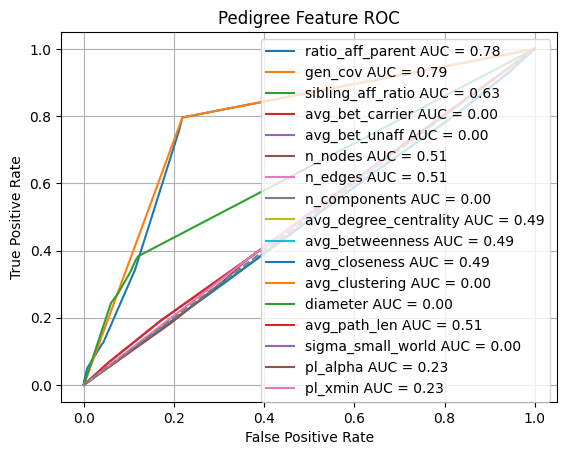

Number of Certain Results: 200/200
Classification Accuracy: 0.83

Predicted Mode of Inheritence: AD
Best Variant in AD Trial:  chr1:100000_A>T 0.914


In [55]:
best_AD_var, AD_scores_raw = scan_variants(G_ad, vars_AD)
print('Best Variant in AD Trial: ', best_AD_var, AD_scores_raw[best_AD_var])


/tmp/ipython-input-27-2104894476.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_trial_feats_df = pd.concat(objs= [all_trial_feats_df, trial_df], ignore_index=True)
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less tha

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.


Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less tha

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less tha

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less tha

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less tha

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less tha

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.


Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less tha

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less tha

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.


Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.


Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.


Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Canno

Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan
Less than 2 unique data values left after xmin and xmax options! Cannot fit. Returning nans.
Not enough data. Returning nan
Not enough data. Returning nan


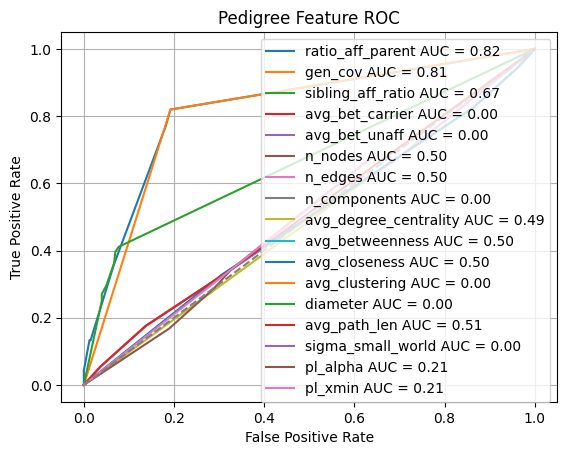

Number of Certain Results: 200/200
Classification Accuracy: 0.845

Predicted Mode of Inheritence: AR
Best Variant in AR Trial:  chr1:100202_G>C 0.84


In [57]:
best_AR_var, AR_scores_raw = scan_variants(G_ar, vars_AR)
print('Best Variant in AR Trial: ', best_AR_var, AR_scores_raw[best_AR_var])

In [63]:
varScores_df_AD = pd.DataFrame(list(AD_scores_raw.items()), columns=['Variant','Score']).sort_values('Score', ascending=False)
var_df_AR = pd.DataFrame(list(AR_scores_raw.items()), columns=['Variant','Score']).sort_values('Score', ascending=False)
print('AD ranking:')
display(varScores_df_AD)
print('AR ranking:')
display(var_df_AR)

AD ranking:


,Variant,Score
0,chr1:100000_A>T,0.914
3,chr1:100202_G>C,0.829
1,chr1:100200_G>C,0.814
2,chr1:100201_G>C,0.814
4,chr1:100203_G>C,0.814
5,chr1:100204_G>C,0.800


AR ranking:


,Variant,Score
3,chr1:100202_G>C,0.84
1,chr1:100200_G>C,0.64
4,chr1:100203_G>C,0.64
0,chr1:100000_A>T,0.46
2,chr1:100201_G>C,0.42
5,chr1:100204_G>C,0.24


#I. Scoring Trials

##II. Manual Generation of Trial Pedigrees:

In [35]:
original_ped_AD = '''\
FAM1 1 0 0 1 2
FAM1 2 0 0 2 1
FAM1 3 1 2 1 2
FAM1 4 1 2 2 1
FAM1 5 0 0 2 1
FAM1 6 3 5 1 2
FAM1 7 3 5 2 1
FAM1 8 0 0 1 1
'''

new_ped_AD = '''\
FAM1 1 0 0 1 2
FAM1 2 0 0 2 1
FAM1 3 1 2 1 2
FAM1 4 1 2 2 1
FAM1 5 0 0 2 1
FAM1 6 3 5 1 2
FAM1 7 3 5 2 1
'''
open('ad_complete.ped','w').write(new_ped_AD)

ped_AR = '''\
FAM2 1 0 0 1 1
FAM2 2 0 0 2 1
FAM2 3 1 2 1 1
FAM2 4 1 2 2 1
FAM2 10 0 0 1 1
FAM2 11 0 0 2 1
FAM2 5 3 11 1 2
FAM2 6 3 11 2 1
FAM2 7 4 10 2 2
FAM2 8 4 10 1 1
'''
open('ar_complete.ped','w').write(ped_AR)

DF_ad = pedfile_readin('ad_complete.ped')
DF_ar = pedfile_readin('ar_complete.ped')
G_ad = construct_pedigree_graph(DF_ad)
G_ar = construct_pedigree_graph(DF_ar)

PyGraphviz not installed. Falling back to spring layout.


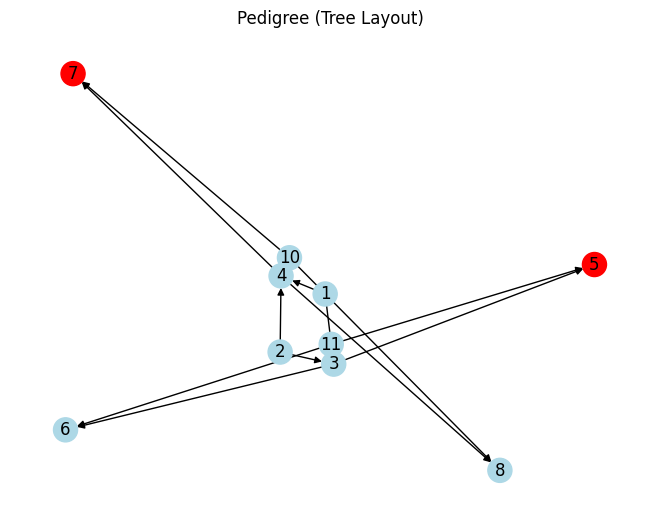

In [36]:
plot_pedigree_tree(G_ar)

##II. Generation of Trial Variant Table
*   with known mode of inheritence



In [47]:
vars_AD = simulate_variant_table(G_ad, 'AD')
vars_AR = simulate_variant_table(G_ar, 'AR')

##Trial Scoring

In [ ]:
best_AD, scores_AD = scan_variants(G_ad, vars_AD, 'AD')
best_AR, scores_AR = scan_variants(G_ar, vars_AR, 'AR')

scores_AD_df = pd.DataFrame(list(scores_AD.items()), columns=['Variant','Score']).sort_values('Score', ascending=False)
scores_AR_df = pd.DataFrame(list(scores_AR.items()), columns=['Variant','Score']).sort_values('Score', ascending=False)

print('Best variant in AD:', best_AD, scores_AD[best_AD])
print('AD ranking:')
display(scores_AD_df)
print('Best variant in AR:', best_AR, scores_AR[best_AR])
print('AR ranking:')
display(scores_AR_df)

Best variant in AD: chr1:100000_A>T 0.925
AD ranking:


,Variant,Score
0,chr1:100000_A>T,0.925
3,chr1:100202_G>C,0.925
1,chr1:100200_G>C,0.825
2,chr1:100201_G>C,0.825
5,chr1:100204_G>C,0.825
4,chr1:100203_G>C,0.800


Best variant in AR: chr1:100202_G>C 0.84
AR ranking:


,Variant,Score
3,chr1:100202_G>C,0.84
1,chr1:100200_G>C,0.64
4,chr1:100203_G>C,0.64
0,chr1:100000_A>T,0.46
2,chr1:100201_G>C,0.42
5,chr1:100204_G>C,0.24
